In [1]:
import io
import os
import glob
import time
import locale
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/Users/edupmon/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

'pt_BR.UTF-8'

In [3]:
pd.set_option('display.float_format',
              lambda x: locale.format_string('%.2f', x, grouping=True))

# Análise da exportação brasileira de vinhos de mesa

## Preparação dos dados

### Período de análise

In [4]:
ano_inicial = 2009
ano_final = 2023

### Obtendo os dados de exportação de vinhos

### Carregando os dados de exportação de vinhos em um dataframe

In [5]:
# Obtendo a lista de arquivos que será carregada no dataframe
arqs_csv = glob.glob(os.path.join('dados', 'exp-vinho-*.csv'))

# Definindo o dataframe que irá receber os dados de todos os arquivos CSV
'''Concatenação dos dataframes obtidos à partir da lista de arquivos (list
   comprehension abaixo), ignorando a primeira linha dos CSVs e definindo o
   nome das colunas manualmente'''
exportacao = pd.concat([pd.read_csv(arq,
                                    skiprows=1,
                                    na_values=0,
                                    names=['pais',
                                           'qtd_litros',
                                           'vlr_usd',
                                           'ano']) for arq in arqs_csv],
                       ignore_index=True)

exportacao['origem'] = 'Brasil'
exportacao['origem_iso_2'] = 'BR'
exportacao['origem_iso_3'] = 'BRA'

exportacao.fillna(0, inplace=True)
exportacao.head()

,pais,qtd_litros,vlr_usd,ano,origem,origem_iso_2,origem_iso_3
0,Afeganistão,"11,00","46,00",2021,Brasil,BR,BRA
1,África do Sul,"0,00","0,00",2021,Brasil,BR,BRA
2,"Alemanha, República Democrática","2.698,00","6.741,00",2021,Brasil,BR,BRA
3,Angola,"0,00","0,00",2021,Brasil,BR,BRA
4,Anguilla,"0,00","0,00",2021,Brasil,BR,BRA


### Análise preliminar da exportação total por país

In [6]:
# Exportação total por país
total_por_pais = exportacao.groupby('pais')[['qtd_litros', 'vlr_usd']]\
                           .sum()\
                           .copy()

total_por_pais.head()

,qtd_litros,vlr_usd
pais,,
Afeganistão,"11,00","46,00"
"Alemanha, República Democrática","648.115,00","2.148.277,00"
Angola,"143.147,00","505.106,00"
Anguilla,"0,00","0,00"
Antilhas Holandesas,"79.064,00","120.007,00"


In [7]:
# Países sem exportação
paises_sem_exportacao = total_por_pais.query('qtd_litros == 0 & vlr_usd == 0')


'''Obtendo a lista de paises com exportação à partir dos conjutos de índices
   dos dois dataframes: total_por_pais - paises_sem_exportacao'''

conj_paises = set(total_por_pais.index.tolist())
conj_paises_sem_exportacao = set(paises_sem_exportacao.index.tolist())

conj_paises_com_exportacao = conj_paises - conj_paises_sem_exportacao


# Países com exportação
paises_com_exportacao = total_por_pais.loc[list(conj_paises_com_exportacao)]
# Adicionando a informação do valor por litro
paises_com_exportacao['usd_por_litro'] = paises_com_exportacao['vlr_usd']\
                                         / paises_com_exportacao['qtd_litros']

print(f'''
Período de análise.............: {ano_inicial} - {ano_final}
Total de países................: {len(conj_paises)} países
Total de países com exportação.: {len(conj_paises_com_exportacao)} países
''')


Período de análise.............: 2009 - 2023
Total de países................: 137 países
Total de países com exportação.: 123 países



### Países com maior volume total (em US$) das exportações

In [8]:
maiores_volumes = paises_com_exportacao.sort_values('vlr_usd',
                                                    ascending=False).head(13)

print(f'Dados do período total: {ano_inicial} - {ano_final}')
display(maiores_volumes)

Dados do período total: 2009 - 2023


,qtd_litros,vlr_usd,usd_por_litro
pais,,,
Paraguai,"30.803.247,00","42.862.206,00","1,39"
Rússia,"32.822.141,00","23.151.716,00","0,71"
Estados Unidos,"3.349.299,00","9.309.051,00","2,78"
China,"2.574.686,00","4.903.695,00","1,90"
Reino Unido,"1.150.780,00","4.640.935,00","4,03"
Espanha,"1.990.238,00","3.805.889,00","1,91"
Haiti,"2.351.228,00","3.198.849,00","1,36"
Países Baixos,"897.986,00","3.012.934,00","3,36"
Japão,"972.341,00","2.257.163,00","2,32"


O tabela acima demonstra, para o período total analisado os maiores volumes
exportados, bem como a variação do valor total em dólares e do valor, em dólar,
por litro para cada um dos países.

Após análise inicial dos dados, optou-se pelo foco nos países cujo volume de
exportação total no período analisado excedeu USD 1.000.000,00, pois, conforme
demonstrado na célula abaixo, estes correspondem a 95% do valor total exportado
em litros e 90% do valor total exportados em USD.

In [9]:
print('Valor total das exportações:')
display(paises_com_exportacao[['qtd_litros', 'vlr_usd']].sum())

print('\nValor total dos países com maior valor nas exportações:')
display(maiores_volumes[['qtd_litros', 'vlr_usd']].sum())

print('\nParticipação dos 12 países no volume total de exportações:')
display(maiores_volumes[['qtd_litros', 'vlr_usd']].sum()\
        / paises_com_exportacao[['qtd_litros', 'vlr_usd']].sum())

Valor total das exportações:


qtd_litros    83.174.997,00
vlr_usd      114.449.292,00
dtype: float64


Valor total dos países com maior valor nas exportações:


qtd_litros    79.264.069,00
vlr_usd      103.406.924,00
dtype: float64


Participação dos 12 países no volume total de exportações:


qtd_litros   0,95
vlr_usd      0,90
dtype: float64

### Enriquecimento dos dados

In [10]:
# Dataframe com dados apenas dos países que possuem exportações
exportacao_analise = exportacao[exportacao['pais']\
                     .isin(maiores_volumes.index.to_list())].copy()
exportacao_analise['usd_por_litro'] = exportacao_analise['vlr_usd']\
                                      / exportacao_analise['qtd_litros']
exportacao_analise.fillna(0, inplace=True)
exportacao_analise.head()

,pais,qtd_litros,vlr_usd,ano,origem,origem_iso_2,origem_iso_3,usd_por_litro
2,"Alemanha, República Democrática","2.698,00","6.741,00",2021,Brasil,BR,BRA,"2,50"
16,Bélgica,"483,00","3.749,00",2021,Brasil,BR,BRA,"7,76"
26,Canadá,"1.172,00","6.157,00",2021,Brasil,BR,BRA,"5,25"
30,China,"61.884,00","264.116,00",2021,Brasil,BR,BRA,"4,27"
49,Espanha,"0,00","0,00",2021,Brasil,BR,BRA,"0,00"


In [11]:
# Incluindo o código ISO dos países

pais_cod_iso = pd.read_csv('dados/pais-cod-iso.csv')
display(pais_cod_iso.head())

exportacao_analise = pd.merge(exportacao_analise, pais_cod_iso,
                              left_on='pais', right_on='pais',
                              how='left')
display(exportacao_analise.head())

,pais,pais_iso_2,pais_iso_3
0,"Alemanha, República Democrática",DE,DEU
1,Angola,AO,AGO
2,Canadá,CA,CAN
3,China,CN,CHN
4,Estados Unidos,US,USA


,pais,qtd_litros,vlr_usd,ano,origem,origem_iso_2,origem_iso_3,usd_por_litro,pais_iso_2,pais_iso_3
0,"Alemanha, República Democrática","2.698,00","6.741,00",2021,Brasil,BR,BRA,"2,50",DE,DEU
1,Bélgica,"483,00","3.749,00",2021,Brasil,BR,BRA,"7,76",NaN,NaN
2,Canadá,"1.172,00","6.157,00",2021,Brasil,BR,BRA,"5,25",CA,CAN
3,China,"61.884,00","264.116,00",2021,Brasil,BR,BRA,"4,27",CN,CHN
4,Espanha,"0,00","0,00",2021,Brasil,BR,BRA,"0,00",NaN,NaN


In [12]:
# Manipulando os dados do Banco Mundial (databank.worldbank.org)

# Carregando os dados do arquivo CSV
banco_mundial = pd.read_csv('dados/databank-worldbank-org.csv', na_values='..')

# Excluindo as colunas que não são relevantes
banco_mundial.drop(['Country Name', 'Series Code'], axis=1, inplace=True)

# Renomeando as colunas
novos_nomes = {'Country Code': 'pais_iso_3', 'Series Name': 'serie',
               '2009 [YR2009]': 2009, '2010 [YR2010]': 2010,
               '2011 [YR2011]': 2011, '2012 [YR2012]': 2012,
               '2013 [YR2013]': 2013, '2014 [YR2014]': 2014,
               '2015 [YR2015]': 2015, '2016 [YR2016]': 2016,
               '2017 [YR2017]': 2017, '2018 [YR2018]': 2018,
               '2019 [YR2019]': 2019, '2020 [YR2020]': 2020,
               '2021 [YR2021]': 2021, '2022 [YR2022]': 2022,
               '2023 [YR2023]': 2023}
banco_mundial.rename(columns=novos_nomes, inplace=True)

# Tratando valores faltantes
intervalo = [i for i in range(ano_inicial, ano_final + 1)]

banco_mundial.loc[:, (intervalo)] = \
    banco_mundial.loc[:, (2009, 2010, 2011, 2012, 2013, 2014, 2015,
                          2016, 2017, 2018, 2019, 2020, 2021, 2022,
                          2023)].interpolate(method='linear',
                                             limit_direction='both', axis=1)

# Ajustando o formato do dataframe para junção com os dados de exportação
banco_mundial = banco_mundial.melt(id_vars=['pais_iso_3', 'serie'],
                                   value_vars=intervalo, value_name='valor',
                                   var_name='ano', ignore_index=True)

banco_mundial = banco_mundial.pivot(index=['pais_iso_3', 'ano'],
                                    columns='serie', values='valor')

banco_mundial.reset_index(inplace=True)
banco_mundial.rename_axis(None, axis=1, inplace=True)

# Renomeando as colunas
nome_coluna_consumo_alcool = 'Total alcohol consumption per capita '
nome_coluna_consumo_alcool += '(liters of pure alcohol, projected estimates, '
nome_coluna_consumo_alcool += '15+ years of age)'

novos_nomes = {'GDP (current US$)': 'pib_usd',
               'GDP per capita (current US$)': 'pib_per_capita',
               nome_coluna_consumo_alcool: 'consumo_litros_alcool_per_capita'}
banco_mundial.rename(columns=novos_nomes, inplace=True)

banco_mundial.head()

,pais_iso_3,ano,pib_usd,pib_per_capita,consumo_litros_alcool_per_capita
0,BRA,2009,"1.666.996.438.681,46","8.569,90","8,63"
1,BRA,2010,"2.208.837.745.214,23","11.249,29","8,63"
2,BRA,2011,"2.616.156.223.977,47","13.200,56","8,54"
3,BRA,2012,"2.465.227.803.011,57","12.327,51","8,46"
4,BRA,2013,"2.472.819.535.742,73","12.258,57","8,37"


In [13]:
# Dados do Banco Mundial no dataframe principal (exportacao_analise)

exportacao_analise = pd.merge(exportacao_analise, banco_mundial,
                              left_on=['pais_iso_3', 'ano'],
                              right_on=['pais_iso_3', 'ano'],
                              how='left')

exportacao_analise.head()

,pais,qtd_litros,vlr_usd,ano,origem,origem_iso_2,origem_iso_3,usd_por_litro,pais_iso_2,pais_iso_3,pib_usd,pib_per_capita,consumo_litros_alcool_per_capita
0,"Alemanha, República Democrática","2.698,00","6.741,00",2021,Brasil,BR,BRA,"2,50",DE,DEU,"4.278.503.934.689,85","51.426,75","12,22"
1,Bélgica,"483,00","3.749,00",2021,Brasil,BR,BRA,"7,76",NaN,NaN,NaN,NaN,NaN
2,Canadá,"1.172,00","6.157,00",2021,Brasil,BR,BRA,"5,25",CA,CAN,"2.007.472.181.464,15","52.515,20","9,90"
3,China,"61.884,00","264.116,00",2021,Brasil,BR,BRA,"4,27",CN,CHN,"17.820.459.508.852,20","12.617,51","5,73"
4,Espanha,"0,00","0,00",2021,Brasil,BR,BRA,"0,00",NaN,NaN,NaN,NaN,NaN


In [14]:
# Incluindo informações de clima da origem (basedosdados.org)

clima_origem = pd.read_csv('dados/basedosdados-org.csv')
display(clima_origem.head())

exportacao_analise = pd.merge(exportacao_analise, clima_origem,
                              left_on='ano', right_on='ano',
                              how='left')
display(exportacao_analise.head())

,ano,precipitacao,temperatura
0,2019,"0,15","23,85"
1,2020,"0,16","23,27"
2,2023,"0,16","23,31"
3,2015,"0,15","23,98"
4,2010,"0,14","23,39"


,pais,qtd_litros,vlr_usd,ano,origem,origem_iso_2,origem_iso_3,usd_por_litro,pais_iso_2,pais_iso_3,pib_usd,pib_per_capita,consumo_litros_alcool_per_capita,precipitacao,temperatura
0,"Alemanha, República Democrática","2.698,00","6.741,00",2021,Brasil,BR,BRA,"2,50",DE,DEU,"4.278.503.934.689,85","51.426,75","12,22","0,16","22,73"
1,Bélgica,"483,00","3.749,00",2021,Brasil,BR,BRA,"7,76",NaN,NaN,NaN,NaN,NaN,"0,16","22,73"
2,Canadá,"1.172,00","6.157,00",2021,Brasil,BR,BRA,"5,25",CA,CAN,"2.007.472.181.464,15","52.515,20","9,90","0,16","22,73"
3,China,"61.884,00","264.116,00",2021,Brasil,BR,BRA,"4,27",CN,CHN,"17.820.459.508.852,20","12.617,51","5,73","0,16","22,73"
4,Espanha,"0,00","0,00",2021,Brasil,BR,BRA,"0,00",NaN,NaN,NaN,NaN,NaN,"0,16","22,73"


In [15]:
# Organizando o dataframe final

exportacao_analise = exportacao_analise[['pais_iso_2', 'pais_iso_3', 'pais',
                                         'ano', 'pib_usd', 'pib_per_capita',
                                         'consumo_litros_alcool_per_capita',
                                         'qtd_litros', 'vlr_usd',
                                         'origem_iso_2', 'origem_iso_3',
                                         'origem', 'precipitacao',
                                         'temperatura']]

exportacao_analise.sort_values(['pais_iso_2', 'ano'], ignore_index=True,
                               inplace=True)

exportacao_analise.to_csv(f'dados/export-vinho-{ano_inicial}-{ano_final}.csv',
                          index=False)

exportacao_analise.head()

,pais_iso_2,pais_iso_3,pais,ano,pib_usd,pib_per_capita,consumo_litros_alcool_per_capita,qtd_litros,vlr_usd,origem_iso_2,origem_iso_3,origem,precipitacao,temperatura
0,CA,CAN,Canadá,2009,"1.374.625.142.157,29","40.876,31","10,21","15.664,00","73.445,00",BR,BRA,Brasil,"0,18","23,32"
1,CA,CAN,Canadá,2010,"1.617.343.367.486,26","47.562,08","10,21","0,00","0,00",BR,BRA,Brasil,"0,14","23,39"
2,CA,CAN,Canadá,2011,"1.793.326.630.174,52","52.223,70","10,15","28.906,00","128.076,00",BR,BRA,Brasil,"0,17","22,92"
3,CA,CAN,Canadá,2012,"1.828.366.481.521,60","52.669,09","10,09","14.304,00","146.035,00",BR,BRA,Brasil,"0,14","23,51"
4,CA,CAN,Canadá,2013,"1.846.597.421.834,98","52.635,17","10,04","25.329,00","174.643,00",BR,BRA,Brasil,"0,17","23,30"


## Análise dos dados tratados

### Descrição dos dados

Este conjunto de dados contém dados de exportação de vinhos do Brasil.

|Coluna|Descrição|
| :--- | :--- |
|pais_iso_2|Código ISO com 2 caracteres do país destino da exportação|
|pais_iso_3|Código ISO com 3 caracteres do país destino da exportação|
|pais|Nome do país destino da exportação|
|ano|Ano referência dos dados da exportação|
|pib_usd|PIB em USD do país destino da exportação|
|pib_per_capita|PIB per capita, em USD do país destino da exportação|
|consumo_litros_alcool_per_capita|Consumo estimado, em litros de álcool puro, per capita do país destino da exportação|
|qtd_litros|Quantidade de litros vendidos pelo Brasil para o país destino da exportação|
|vlr_usd|Valor em USD das exportações do Brasil para o país destino|
|origem_iso_2|Código ISO com 2 caracteres do pais origem das exportações|
|origem_iso_3|Código ISO com 3 caracteres do país origem das exportações|
|origem|Nome do país origem das exportações|
|precipitacao|Volume médio de chuva em mm no país origem das exportações|
|temperatura|Temperatura média em graus celsius no país origem das exportações|

In [16]:
exportacao_analise.head()

,pais_iso_2,pais_iso_3,pais,ano,pib_usd,pib_per_capita,consumo_litros_alcool_per_capita,qtd_litros,vlr_usd,origem_iso_2,origem_iso_3,origem,precipitacao,temperatura
0,CA,CAN,Canadá,2009,"1.374.625.142.157,29","40.876,31","10,21","15.664,00","73.445,00",BR,BRA,Brasil,"0,18","23,32"
1,CA,CAN,Canadá,2010,"1.617.343.367.486,26","47.562,08","10,21","0,00","0,00",BR,BRA,Brasil,"0,14","23,39"
2,CA,CAN,Canadá,2011,"1.793.326.630.174,52","52.223,70","10,15","28.906,00","128.076,00",BR,BRA,Brasil,"0,17","22,92"
3,CA,CAN,Canadá,2012,"1.828.366.481.521,60","52.669,09","10,09","14.304,00","146.035,00",BR,BRA,Brasil,"0,14","23,51"
4,CA,CAN,Canadá,2013,"1.846.597.421.834,98","52.635,17","10,04","25.329,00","174.643,00",BR,BRA,Brasil,"0,17","23,30"


In [17]:
# Estatistica descritiva dos dados
exportacao_analise[['pib_usd', 'pib_per_capita',
                    'consumo_litros_alcool_per_capita',
                    'qtd_litros', 'vlr_usd', 'precipitacao',
                    'temperatura']].describe()

,pib_usd,pib_per_capita,consumo_litros_alcool_per_capita,qtd_litros,vlr_usd,precipitacao,temperatura
count,"135,00","135,00","135,00","195,00","195,00","195,00","195,00"
mean,"5.261.972.191.120,69","35.127,39","9,16","406.482,41","530.291,92","0,16","23,37"
std,"6.246.110.862.095,11","19.893,03","2,31","1.803.083,31","1.524.944,61","0,01","0,35"
min,"22.355.151.161,99","3.832,23","5,41","0,00","0,00","0,14","22,73"
25%,"1.433.850.518.259,71","11.411,81","6,71","2.598,00","7.682,00","0,15","23,27"
50%,"2.784.853.502.534,29","42.136,12","9,57","34.295,00","112.342,00","0,16","23,37"
75%,"5.165.161.017.091,34","48.952,68","10,73","135.826,50","398.565,00","0,16","23,60"
max,"25.439.700.000.000,00","76.329,58","13,76","21.912.914,00","14.795.694,00","0,18","23,98"


In [18]:
# Exportação total por país
exp_total_pais = exportacao_analise.groupby('pais')[['qtd_litros', 'vlr_usd']]\
                                   .sum().reset_index()

exp_total_pais

,pais,qtd_litros,vlr_usd
0,"Alemanha, República Democrática","648.115,00","2.148.277,00"
1,Bélgica,"399.239,00","1.382.940,00"
2,Canadá,"186.081,00","1.059.120,00"
3,China,"2.574.686,00","4.903.695,00"
4,Espanha,"1.990.238,00","3.805.889,00"
5,Estados Unidos,"3.349.299,00","9.309.051,00"
6,Haiti,"2.351.228,00","3.198.849,00"
7,Japão,"972.341,00","2.257.163,00"
8,Paraguai,"30.803.247,00","42.862.206,00"
9,Países Baixos,"897.986,00","3.012.934,00"


In [19]:
# PIB médio por país
pib_medio_pais = exportacao_analise.groupby('pais')[['pib_usd',
                                                     'pib_per_capita']]\
                                   .mean().reset_index()

pib_medio_pais

,pais,pib_usd,pib_per_capita
0,"Alemanha, República Democrática","3.761.557.618.089,97","45.757,06"
1,Bélgica,NaN,NaN
2,Canadá,"1.763.663.743.383,14","48.533,92"
3,China,"11.902.234.045.969,75","8.559,86"
4,Espanha,NaN,NaN
5,Estados Unidos,"19.288.137.108.933,33","59.666,61"
6,Haiti,NaN,NaN
7,Japão,"5.120.316.498.833,88","40.335,18"
8,Paraguai,"36.253.332.105,26","5.767,05"
9,Países Baixos,"893.229.608.395,54","52.232,72"


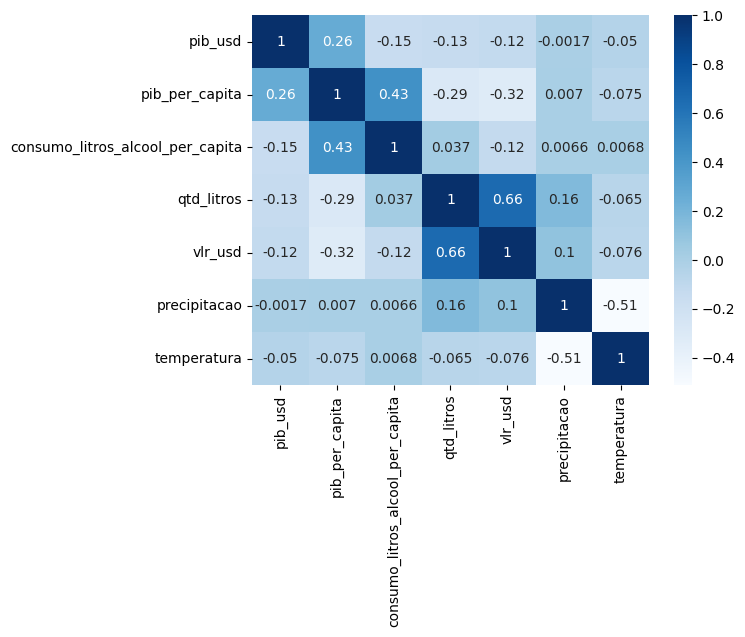

In [20]:
# Correlation matrix
matriz_correlacao = exportacao_analise[['pib_usd', 'pib_per_capita',
                                        'consumo_litros_alcool_per_capita',
                                        'qtd_litros', 'vlr_usd',
                                        'precipitacao', 'temperatura']].corr()

sns.heatmap(matriz_correlacao, cmap="Blues", annot=True)
plt.show()

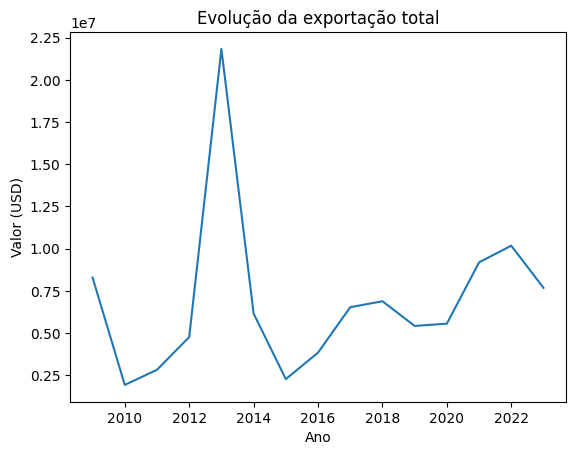

In [21]:
# Evolução da exportação total
exportacao_analise.groupby('ano')['vlr_usd'].sum()\
                  .plot(kind='line', title='Evolução da exportação total',
                        ylabel='Valor (USD)', xlabel='Ano')
plt.show()

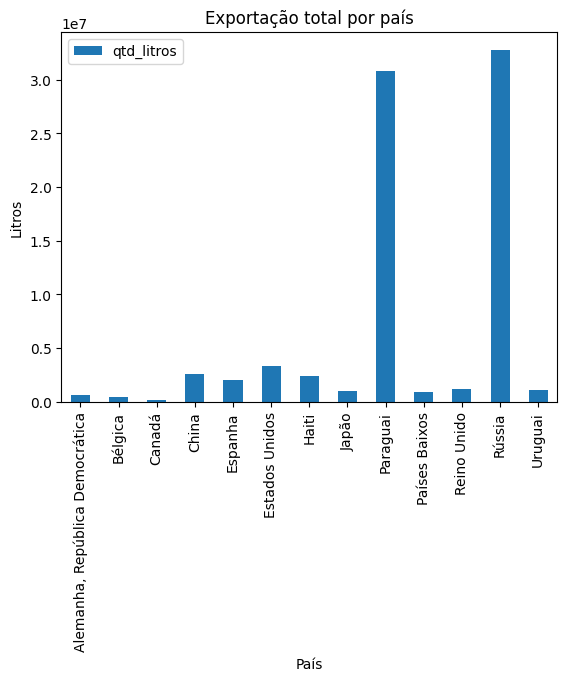

In [22]:
# Exportação total por país
exp_total_pais.plot(kind='bar', x='pais', y='qtd_litros',
                    title='Exportação total por país', ylabel='Litros',
                    xlabel='País')
plt.show()